# Hồi quy Gamma với tensorflow probability

### BS. Lê Ngọc Khả Nhi

# Nhập đề

Giá trị tham chiếu của xét nghiệm có ý nghĩa quan trọng trong thực hành lâm sàng. Thông thường, người bác sĩ cần đối chiếu kết quả xét nghiệm của một bệnh nhân với ngưỡng trên hoặc dưới của phân bố đại lượng đó trong quần thể người bình thường, từ đó xác định liệu kết quả của bệnh nhân có tăng hoặc giảm một cách bất thường hay không.

Các mô hình hồi quy của thống kê cổ điển đã góp phần rất lớn giúp xây dựng các khoảng giá trị tham chiếu trong y học. Người ta đã sử dụng những mô hình tuyến tính tổng quát (GLM) với phân phối Gaussian trong hàng chục năm, rồi khoảng 10 năm trước, ta biết đến mô hình GAMLSS mạnh và linh hoạt hơn. Hiện nay, ta có thêm một công cụ còn tốt hơn nữa, đó là Deep learning với probabilistic layer.


# Mục tiêu

Trong bài thực hành này, Nhi sẽ làm một thí nghiệm sử dụng keras và tensorflow probability để dựng một mô hình Deep neural network với probabilistic output layer, mô hình này xuất ra kết quả là một phân phối Gamma, từ đó cho phép ước tính ngưỡng giá trị tham chiếu cho 1 xét nghiệm sinh lý có tên là DLCO, dựa vào Tuổi, chiều cao và giới tính của bệnh nhân.

In [1]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

# Chuẩn bị dữ liệu

In [2]:
def data_load(file_path = None):
    df=pd.read_csv(file_path, sep=';')
    df = pd.get_dummies(df, drop_first=True)
    
    X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[:,[0,1,3]],
                                                    df['DLCO'],
                                                    test_size=0.05,
                                                    random_state=123)
    
    return X_train, X_test, Y_train, Y_test

In [4]:
X_train, X_test, Y_train, Y_test = data_load("https://raw.githubusercontent.com/kinokoberuji/R-Tutorials/master/DLCOkeras1.csv")

In [19]:
X_train

,Age,Height,Sex_M
54,18,170.0,0
181,87,154.0,0
521,49,186.0,1
132,56,167.0,0
391,28,179.0,1
...,...,...,...
98,43,161.0,0
322,24,166.5,1
382,24,178.0,1
365,18,172.0,1


# Thăm dò trực quan

Ta lần lượt vẽ biểu đồ KDE plot, regression plot để khảo sát:

1) Phân bố của DLCO giữa 2 giới tính

2) Quan hệ giữa DLCO và Age, giữa 2 giới tính

3) Quan hệ giữa DLCO và Tuổi, giữa 2 giới tính

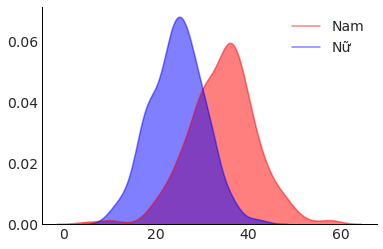

In [31]:
sns.kdeplot(Y_train[X_train.Sex_M == 1], shade = True, 
            color = 'red',  
            alpha = 0.5, 
            label = 'Nam')

sns.kdeplot(Y_train[X_train.Sex_M == 0], 
            shade = True, 
            color = 'blue',  
            alpha = 0.5, 
            label = 'Nữ')

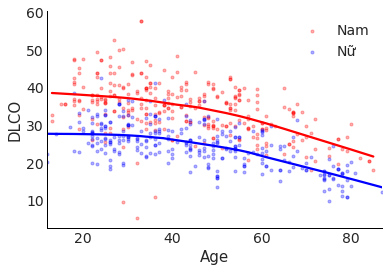

In [44]:
sns.regplot(x=X_train.Age[X_train.Sex_M == 1],
            y=Y_train[X_train.Sex_M == 1],
            lowess = True, 
            marker = ".",
            color = 'red',
            label = 'Nam',
            scatter_kws={'alpha':0.3, 'color':'red'},)

sns.regplot(x=X_train.Age[X_train.Sex_M == 0],
            y=Y_train[X_train.Sex_M == 0],
            lowess = True, marker = ".",
            color = 'blue',
            label = 'Nữ',
            scatter_kws={'alpha':0.3, 'color':'blue'},)

plt.legend()

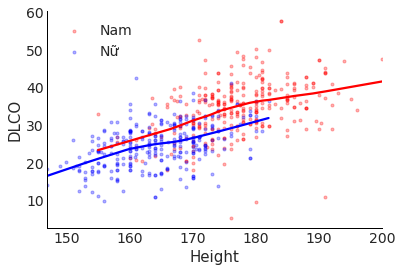

In [45]:
sns.regplot(x=X_train.Height[X_train.Sex_M == 1],
            y=Y_train[X_train.Sex_M == 1],
            lowess = True, 
            marker = ".",
            color = 'red',
            label = 'Nam',
            scatter_kws={'alpha':0.3, 'color':'red'},)

sns.regplot(x=X_train.Height[X_train.Sex_M == 0],
            y=Y_train[X_train.Sex_M == 0],
            lowess = True, marker = ".",
            color = 'blue',
            label = 'Nữ',
            scatter_kws={'alpha':0.3, 'color':'blue'},)

plt.legend()

# Phân phối Gamma trong tensorflow probability

Gamma là 1 phân phối với hình dạng thay đổi linh hoạt từ đối xứng cho đến lệch phải, do đó rất phù hợp để ước lượng những đại lượng sinh học với thang đo là số dương.

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp

from keras.models import Sequential
from keras.layers import Dense, Activation

tfd = tfp.distributions

Using TensorFlow backend.


Phân bố Gamma được xác định bằng 2 tham số concentration (alpha) và rate (beta),

Cho một biến ngẫu nhiên X có giá trị dương, với giả định x = Gamma(alpha, beta), 
hàm PDF của X có nội dung:

pdf(x; alpha, beta, x > 0) = x**(alpha - 1) exp(-x beta) / Z

với Z = Gamma(alpha) beta**(-alpha)

Thí nghiệm mô phỏng sau cho biết ảnh hưởng riêng biệt của alpha và beta đối với hình dạng phân bố của x:

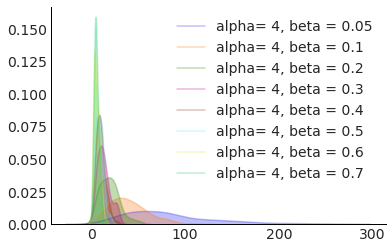

In [47]:
for beta in [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    concentration = tf.constant(4.0)
    rate = tf.constant(beta)
    dist = tfd.Gamma(concentration, rate)
    samples = dist.sample(100).numpy()
    
    sns.kdeplot(pd.Series(samples, name = str(f'alpha= 4, beta = {beta}')), 
                shade = True, alpha = 0.3)

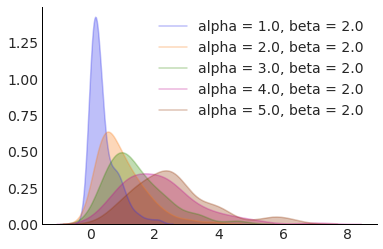

In [48]:
for alpha in [1.0,2.0,3.0,4.0,5.0]:
    concentration = tf.constant(alpha)
    rate = tf.constant(2.0)
    dist = tfd.Gamma(concentration, rate)
    samples = dist.sample(100).numpy()
    
    sns.kdeplot(pd.Series(samples, name = str(f'alpha = {alpha}, beta = 2.0')), shade = True, alpha = 0.3)

# Mô hình Deep learning probabilistic Gamma

Ta sẽ xây dựng một mạng Deep neural network với cấu trúc Sequential như sau:

1) Input layer gồm 3 neurons, tiếp nhận 2D tensor (batch size x 3 features là Height, Weight và Sex_M)

2) 1 hidden layer với 64 neurons

3) Output là một probabilistic layer sử dụng phân bố Gamma

Mục tiêu huấn luyện là giảm tối thiểu giá trị của hàm negative log-likelihood của phân bố Gamma, để xác định giá trị tối ưu của 2 tham số alpha và beta 

Như vậy output của mô hình không phải là 1 kết quả xác định (deterministic), nhưng là giá trị ngẫu nhiên (probabilistic), tuân theo quy luật phân phối Gamma(alpha, beta)

In [18]:
gamma_loss = lambda x, rv_x: -tf.reduce_mean(rv_x.log_prob(x))

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1+1),
    tfp.layers.DistributionLambda(lambda t: tfd.Gamma(concentration = tf.math.softplus(t[..., :1]),
                          rate = tf.math.softplus(0.001 + 0.01*t[..., :1]))), ])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=gamma_loss)

Huấn luyện mô hình 

In [19]:
model.fit(X_train.values,
          Y_train.values, 
          epochs=50, 
          batch_size=16)

Train on 605 samples
Epoch 1/50
605/605 [==============================] - 0s 690us/sample - loss: 5.2232
Epoch 2/50
605/605 [==============================] - 0s 176us/sample - loss: 3.3604
Epoch 3/50
605/605 [==============================] - 0s 150us/sample - loss: 3.2397
Epoch 4/50
605/605 [==============================] - 0s 161us/sample - loss: 3.2229
Epoch 5/50
605/605 [==============================] - 0s 167us/sample - loss: 3.2549
Epoch 6/50
605/605 [==============================] - 0s 165us/sample - loss: 3.2962
Epoch 7/50
605/605 [==============================] - 0s 198us/sample - loss: 3.2828
Epoch 8/50
605/605 [==============================] - 0s 180us/sample - loss: 3.1832
Epoch 9/50
605/605 [==============================] - 0s 164us/sample - loss: 3.2657
Epoch 10/50
605/605 [==============================] - 0s 177us/sample - loss: 3.2473
Epoch 11/50
605/605 [==============================] - 0s 171us/sample - loss: 3.2029
Epoch 12/50
605/605 [=====================

Xem cấu trúc mô hình

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              multiple                  256       
_________________________________________________________________
dense_7 (Dense)              multiple                  130       
_________________________________________________________________
distribution_lambda_3 (Distr multiple                  0         
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


# Sử dụng mô hình trên test set

Sau khi huấn luyện, ta thử áp dụng mô hình để predict test set

Lưu ý rằng output của mô hình không phải là 1 giá trị xác định nhưng ngẫu nhiên, do đó mỗi lần predict, mô hình sẽ cho ra 1 kết quả khác nhau.

Sau đây là hình ảnh của 10 lượt predict trên cùng test-set, ta sẽ có 10 phân bố khác nhau của DLCO trong tập testset, tuy nhiên chúng khá tương đồng với ít sai biệt

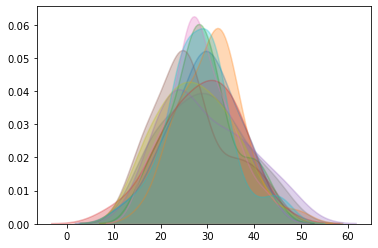

In [53]:
for i in range(10):
    pi = model.predict(X_test.values).flatten()
    sns.kdeplot(pi,
                shade = True, 
                alpha = 0.3)

Tương tự, ta có thể vẽ 10 đồ thị khác nhau mô tả liên hệ giữa giá trị DLCo dự báo và Tuổi: 

[Text(0, 0.5, 'Predicted DLCO'), Text(0.5, 0, 'Age')]

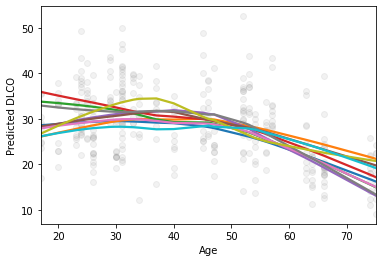

In [54]:
for i in range(10):
    pi = model.predict(X_test.values).flatten()
    g = sns.regplot(X_test.values[:,0], pi, lowess = True, 
                scatter_kws={'alpha':0.1, 'color':'grey'},)

g.set(ylabel='Predicted DLCO', xlabel='Age')

Ý nghĩa lâm sàng của mô hình đó là khi áp dụng mô hình cho từng cá thể bệnh nhân và lặp lại rất nhiều (N) lần, ta sẽ ước lượng được 1 phân phối của giá trị DLCO bình thường của một quần thể giả định gồm N cá thể có cùng tuổi, chiều cao, cân nặng và giới tính. Thậm chí ta có thể nhìn thấy hình ảnh phân phối này, và định vị được các bách phân vị:

In [21]:
# Case thứ 2 trong tập test-set có DLCO thực tế = 32.2

Y_test.values[1]

32.2

In [22]:
# Áp dụng 100 lần prediction cho case thứ 2 này

p = np.array([])

for i in range(100):
    pi = np.array([float(model.predict(X_test.values[1].reshape(1,3)))])
    p = np.append(p, pi)

Đây là hình ảnh phân bố của DLCO cho quần thể giả định gồm 100 người có cùng đặc tính features như case thứ 2 này:

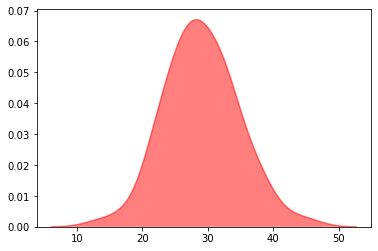

In [23]:
sns.kdeplot(p, shade = True, color = 'red', alpha = 0.5)

Thống kê mô tả cho thấy bách phân vị thứ 5 = 21.386, đây có thể xem là ngưỡng dưới của giá trị bình thường.

Nếu kết quả DLCO thực tế của bệnh nhân thấp hơn 21.386, ta có thể kết luận DLCO của người đó bị giảm bất thường.

In [24]:
pd.Series(p).describe(percentiles = [0.025,0.05,0.1,0.5])

count    100.000000
mean      29.050879
std        5.619515
min       13.259501
2.5%      18.953295
5%        21.386815
10%       22.079288
50%       28.582405
max       45.585487
dtype: float64

Bài thực hành đến đây là hết, xin tạm biệt các bạn và hẹn gặp lại :)